In [1]:
import os
os.environ['TF_ENABLE_LAYOUT_OPTIMIZER'] = '0'

import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

import tensorflow.keras.backend as K
import gc

K.clear_session()
gc.collect()


2025-06-29 11:22:42.939419: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751170962.961012  139169 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751170962.967207  139169 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-29 11:22:43.005002: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Num GPUs Available: 1


0

In [ ]:
# ----------------------------
# Phonetic Map (ID to string)
# ----------------------------
phonetic_map = {
    1: "a", 2: "i", 3: "u", 4: "e", 
    5: "o", 6: "é", 7: "eu",
    8: "ka", 9: "ga", 10: "nga", 11: "ca", 
    12: "ja", 13: "nya",
    14: "ta", 15: "da", 16: "na", 17: "pa", 
    18: "ba", 19: "ma",
    20: "ya", 21: "ra", 22: "la", 23: "wa", 
    24: "sa", 25: "ha",
    26: "fa", 27: "qa", 28: "va", 29: "xa", 
    30: "za", 31: "sya", 32: "kha",
    33: "-i", 34: "-u", 35: "-é", 36: "-e", 
    37: "-eu", 38: "-o",
    39: "-r", 40: "-h", 41: "-ng", 42: "-", 
    43: "-r-", 44: "-y-", 45: "-l-"
}

In [3]:
import os
import json
import numpy as np
import tensorflow as tf
from PIL import Image
from tensorflow.keras import layers, Model, callbacks
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import EfficientNetB0


# ----------------------------
# Data Generator
# ----------------------------
class CTCDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, json_path, batch_size=32, image_size=(224, 224), shuffle=True, **kwargs):
        super().__init__(**kwargs)
        with open(json_path, 'r', encoding='utf-8') as f:
            self.data = json.load(f)

        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.data))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))
        

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_data = [self.data[k] for k in batch_indexes]

        images = np.zeros((len(batch_data), *self.image_size, 3), dtype=np.float32)
        labels = []
        input_lengths = []
        label_lengths = []

        for i, item in enumerate(batch_data):
            img = Image.open(item["url_file"]).convert("RGB")
            img = img.resize(self.image_size)
            img = np.asarray(img).astype(np.float32) / 255.0
            images[i] = img
            labels.append(item["label"])
            input_lengths.append(item["input_length"] if isinstance(item["input_length"], int) else item["input_length"][0])
            label_lengths.append(item["label_length"] if isinstance(item["label_length"], int) else item["label_length"][0])

        if len(label_lengths) == 0:
            print(f"Batch kosong pada index {index}. Melewati.")
            raise StopIteration  # atau cukup continue
        
        max_label_len = max(label_lengths)
        padded_labels = np.full((len(labels), max_label_len), -1, dtype=np.int32)
        
        for i, l in enumerate(labels):
            padded_labels[i, :len(l)] = l
       
        return (
            {
                "image_ctc": images,
                "labels": padded_labels,
                "input_length": np.array(input_lengths).reshape(-1, 1),
                "label_length": np.array(label_lengths).reshape(-1, 1),
            },
            # np.zeros((len(images)))
            np.zeros((len(images), 1), dtype=np.float32)
            # None
        )

# ----------------------------
# CTC Loss Layer
# ----------------------------
@tf.keras.utils.register_keras_serializable()
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    return tf.keras.backend.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [4]:
# ----------------------------
# EfficientNetB0 + CNN-RNN + CTC Model
# ----------------------------
def build_efficientnet_cnn_rnn_ctc(vocab_size=51, input_shape=(224, 224, 3)):
    input_img = layers.Input(shape=input_shape, name='image_ctc')
    base_model = EfficientNetB0(include_top=False, input_tensor=input_img, weights='imagenet')

    FINE_TUNE = True
    if not FINE_TUNE:
        base_model.trainable = False  # Bekukan semua layer
    else:
        # Opsi 1: Fine-tune sebagian dari layer (misal mulai dari layer ke-200)
        fine_tune_at = 163
        for layer in base_model.layers[:fine_tune_at]:
            layer.trainable = False
        for layer in base_model.layers[fine_tune_at:]:
            layer.trainable = True

    x = base_model.output
    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = layers.Reshape((x.shape[1], x.shape[2] * x.shape[3]))(x)
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
    x = layers.Dropout(0.2)(x)
    logits = layers.Dense(vocab_size, activation='softmax', name='logits')(x)

    labels = layers.Input(name='labels', shape=(None,), dtype='int32')
    input_length = layers.Input(name='input_length', shape=(1,), dtype='int32')
    label_length = layers.Input(name='label_length', shape=(1,), dtype='int32')
    loss_out = layers.Lambda(ctc_lambda_func, name='ctc')([logits, labels, input_length, label_length])

    model = Model(inputs=[input_img, labels, input_length, label_length], outputs=loss_out)

    return model

In [11]:
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import json, os
import csv
import tensorflow as tf
from tensorflow.keras import callbacks, Model

class LearningRateLogger(callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))


EPOCHS = 30
vocab_size = max(phonetic_map.keys()) + 1  # Pastikan gunakan nilai

def run_stratified_kfold(json_path, n_splits=5, batch_size=32, image_size=(224, 224)):
    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    def extract_folder_label(path):
        parts = path.replace("\\", "/").split("/")
        if "training" in parts:
            idx = parts.index("training")
            if idx + 1 < len(parts):
                return parts[idx + 1]
        return "unknown"

    labels = [extract_folder_label(item["url_file"]) for item in data]

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    for fold, (train_idx, val_idx) in enumerate(skf.split(data, labels)):
        print(f"\n🔁 Fold {fold + 1}/{n_splits}")

        train_data = [data[i] for i in train_idx]
        val_data = [data[i] for i in val_idx]

        os.makedirs("ctc_dataset/tmp_split_2", exist_ok=True)
        with open(f"ctc_dataset/tmp_split_2/train_fold_{fold}.json", 'w', encoding='utf-8') as f_train:
            json.dump(train_data, f_train, ensure_ascii=False)
        with open(f"ctc_dataset/tmp_split_2/val_fold_{fold}.json", 'w', encoding='utf-8') as f_val:
            json.dump(val_data, f_val, ensure_ascii=False)

        train_gen = CTCDataGenerator(f"ctc_dataset/tmp_split_2/train_fold_{fold}.json", batch_size=batch_size, image_size=image_size)
        val_gen = CTCDataGenerator(f"ctc_dataset/tmp_split_2/val_fold_{fold}.json", batch_size=batch_size, image_size=image_size)

        train_dataset = tf.data.Dataset.from_generator(
            lambda: train_gen,
            output_signature=(
                {
                    "image_ctc": tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
                    "labels": tf.TensorSpec(shape=(None, None), dtype=tf.int32),
                    "input_length": tf.TensorSpec(shape=(None, 1), dtype=tf.int32),
                    "label_length": tf.TensorSpec(shape=(None, 1), dtype=tf.int32),
                },
                tf.TensorSpec(shape=(None, 1), dtype=tf.float32),
            )
        )

        val_dataset = tf.data.Dataset.from_generator(
            lambda: val_gen,
            output_signature=(
                {
                    "image_ctc": tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
                    "labels": tf.TensorSpec(shape=(None, None), dtype=tf.int32),
                    "input_length": tf.TensorSpec(shape=(None, 1), dtype=tf.int32),
                    "label_length": tf.TensorSpec(shape=(None, 1), dtype=tf.int32),
                },
                tf.TensorSpec(shape=(None, 1), dtype=tf.float32),
            )
        )

        # === Build & Compile model ===
        model = build_efficientnet_cnn_rnn_ctc(vocab_size=vocab_size)

        initial_lr = 1e-4
        optimizer = tf.keras.optimizers.Adam(learning_rate=initial_lr)
        model.compile(optimizer=optimizer, loss=lambda y_true, y_pred: y_pred)

        # === Direktori Simpan ===
        save_dir = "ctc_dataset/saved_models/finetune_v2/"
        os.makedirs(save_dir, exist_ok=True)

        # === Callback ===
        checkpoint = callbacks.ModelCheckpoint(
            f"{save_dir}/best_model_fold_{fold}.h5", monitor='val_loss', save_best_only=True, verbose=1)
        early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        lr_reduce = callbacks.ReduceLROnPlateau(factor=0.5, patience=3, verbose=1)
        lr_logger = LearningRateLogger()

        # === Training ===
        steps_per_epoch = len(train_gen)
        validation_steps = len(val_gen)

        history = model.fit(
            train_dataset,
            validation_data=val_dataset,
            steps_per_epoch=steps_per_epoch,
            validation_steps=validation_steps,
            epochs=EPOCHS,
            callbacks=[checkpoint, early_stop, lr_reduce, lr_logger]
        )

        # === Simpan Model Inference ===
        input_img = model.inputs[0]
        logits_out = model.get_layer("logits").output
        inference_model = tf.keras.Model(inputs=input_img, outputs=logits_out)
        inference_model.save(f"{save_dir}/infer_model_fold_{fold}.h5")

        # === Plot Loss ===
        plt.figure(figsize=(5, 5))

        epochs = range(1, len(history.history['loss']) + 1)
        train_loss = history.history['loss']
        val_loss = history.history['val_loss']
        learning_rates = history.history.get('lr') or [initial_lr] * len(epochs)

        # Cari titik minimum val_loss
        val_min_epoch = np.argmin(val_loss) + 1
        val_min_value = np.min(val_loss)

        # Plot loss
        plt.plot(epochs, train_loss, label='Training Loss', color='blue', marker='.')
        plt.plot(epochs, val_loss, label=f'Validation Loss (min: {val_min_value:.4f} at epoch {val_min_epoch})', color='orange', marker='.')

        plt.scatter(val_min_epoch, val_min_value, color='orange', s=40, zorder=5)
        plt.text(val_min_epoch, val_min_value + 0.01, f'{val_min_value:.4f}', color='orange', fontsize=9)

        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f'Fold {fold + 1} - Training vs Validation Loss')
        plt.grid(True)
        plt.legend(loc='upper right')
        plt.tight_layout()

        # Simpan plot
        plot_path = f"{save_dir}/loss_plot_fold_{fold}.png"
        plt.savefig(plot_path)
        plt.close()
        print(f"📉 Loss plot saved to {plot_path}")

        # === Simpan history ke CSV ===
        csv_path = f"{save_dir}/history_fold_{fold}.csv"
        with open(csv_path, 'w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(['Epoch', 'Training Loss', 'Validation Loss', 'Learning Rate'])
            for i, (tl, vl, lr) in enumerate(zip(train_loss, val_loss, learning_rates)):
                writer.writerow([i + 1, tl, vl, lr])

        print(f"📄 Training history saved to {csv_path}")

# Jalankan
run_stratified_kfold("ctc_dataset/combined_file_list_training.json", n_splits=5, batch_size=32)



🔁 Fold 1/5
Epoch 1/30


E0000 00:00:1751180411.889766  139169 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_9_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


498/499 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 7.6989Batch kosong pada index 499. Melewati.
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 7.6962Batch kosong pada index 125. Melewati.

Epoch 1: val_loss improved from inf to 5.67930, saving model to ctc_dataset/saved_models/finetune_v2//best_model_fold_0.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 116s 192ms/step - loss: 7.6935 - val_loss: 5.6793 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 2/30


2025-06-29 14:01:49.435223: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8724109497792043598
2025-06-29 14:01:49.435327: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13293216059606446980
2025-06-29 14:01:49.435342: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3779690974262757409
2025-06-29 14:01:49.435350: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8853120486620483151
/home/gaaf/thesis-ocr-aksara-sunda/.venv/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Batch kosong pada index 125. Melewati.

Epoch 2: val_loss did not improve from 5.67930
499/499 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - loss: 0.0000e+00 - val_loss: 5.6793 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 3/30
498/499 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 4.6714Batch kosong pada index 499. Melewati.
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 4.6707Batch kosong pada index 125. Melewati.

Epoch 3: val_loss improved from 5.67930 to 3.89794, saving model to ctc_dataset/saved_models/finetune_v2//best_model_fold_0.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 93s 186ms/step - loss: 4.6700 - val_loss: 3.8979 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 4/30


2025-06-29 14:03:34.380525: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8724109497792043598
2025-06-29 14:03:34.380610: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13293216059606446980
2025-06-29 14:03:34.380626: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3779690974262757409
2025-06-29 14:03:34.380635: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8853120486620483151


Batch kosong pada index 125. Melewati.

Epoch 4: val_loss did not improve from 3.89794
499/499 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - loss: 0.0000e+00 - val_loss: 3.8979 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 5/30
498/499 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 3.3403Batch kosong pada index 499. Melewati.
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 3.3399Batch kosong pada index 125. Melewati.

Epoch 5: val_loss improved from 3.89794 to 2.86488, saving model to ctc_dataset/saved_models/finetune_v2//best_model_fold_0.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 93s 186ms/step - loss: 3.3396 - val_loss: 2.8649 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 6/30


2025-06-29 14:05:19.876388: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8724109497792043598
2025-06-29 14:05:19.876454: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13293216059606446980
2025-06-29 14:05:19.876473: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3779690974262757409
2025-06-29 14:05:19.876482: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8853120486620483151


Batch kosong pada index 125. Melewati.

Epoch 6: val_loss did not improve from 2.86488
499/499 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - loss: 0.0000e+00 - val_loss: 2.8649 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 7/30
498/499 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 2.7219Batch kosong pada index 499. Melewati.
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 2.7217Batch kosong pada index 125. Melewati.

Epoch 7: val_loss improved from 2.86488 to 2.37433, saving model to ctc_dataset/saved_models/finetune_v2//best_model_fold_0.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 93s 186ms/step - loss: 2.7216 - val_loss: 2.3743 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 8/30


2025-06-29 14:07:06.210019: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8724109497792043598
2025-06-29 14:07:06.210085: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13293216059606446980
2025-06-29 14:07:06.210105: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3779690974262757409
2025-06-29 14:07:06.210122: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8853120486620483151


Batch kosong pada index 125. Melewati.

Epoch 8: val_loss did not improve from 2.37433
499/499 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - loss: 0.0000e+00 - val_loss: 2.3743 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 9/30
498/499 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 2.3797Batch kosong pada index 499. Melewati.
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 2.3795Batch kosong pada index 125. Melewati.

Epoch 9: val_loss improved from 2.37433 to 2.23308, saving model to ctc_dataset/saved_models/finetune_v2//best_model_fold_0.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 143s 286ms/step - loss: 2.3794 - val_loss: 2.2331 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 10/30


2025-06-29 14:09:41.511921: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8724109497792043598
2025-06-29 14:09:41.512000: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13293216059606446980
2025-06-29 14:09:41.512025: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3779690974262757409
2025-06-29 14:09:41.512039: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8853120486620483151


Batch kosong pada index 125. Melewati.

Epoch 10: val_loss did not improve from 2.23308
499/499 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - loss: 0.0000e+00 - val_loss: 2.2331 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 11/30
498/499 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 2.0819Batch kosong pada index 499. Melewati.
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 2.0818Batch kosong pada index 125. Melewati.

Epoch 11: val_loss improved from 2.23308 to 1.81477, saving model to ctc_dataset/saved_models/finetune_v2//best_model_fold_0.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 92s 185ms/step - loss: 2.0817 - val_loss: 1.8148 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 12/30


2025-06-29 14:11:26.556636: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8724109497792043598
2025-06-29 14:11:26.556686: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13293216059606446980
2025-06-29 14:11:26.556701: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3779690974262757409
2025-06-29 14:11:26.556709: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8853120486620483151


Batch kosong pada index 125. Melewati.

Epoch 12: val_loss did not improve from 1.81477
499/499 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.0000e+00 - val_loss: 1.8148 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 13/30
498/499 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 1.8495Batch kosong pada index 499. Melewati.
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 1.8494Batch kosong pada index 125. Melewati.

Epoch 13: val_loss did not improve from 1.81477
499/499 ━━━━━━━━━━━━━━━━━━━━ 90s 181ms/step - loss: 1.8493 - val_loss: 2.0122 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 14/30


2025-06-29 14:13:08.190106: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8724109497792043598
2025-06-29 14:13:08.190173: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13293216059606446980
2025-06-29 14:13:08.190189: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3779690974262757409
2025-06-29 14:13:08.190200: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8853120486620483151


Batch kosong pada index 125. Melewati.

Epoch 14: val_loss did not improve from 1.81477

Epoch 14: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
499/499 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 0.0000e+00 - val_loss: 2.0122 - learning_rate: 1.0000e-04 - lr: 5.0000e-05
Epoch 15/30
498/499 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 1.5699Batch kosong pada index 499. Melewati.
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 1.5697Batch kosong pada index 125. Melewati.

Epoch 15: val_loss improved from 1.81477 to 1.44241, saving model to ctc_dataset/saved_models/finetune_v2//best_model_fold_0.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 93s 186ms/step - loss: 1.5696 - val_loss: 1.4424 - learning_rate: 5.0000e-05 - lr: 5.0000e-05
Epoch 16/30


2025-06-29 14:14:53.555871: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8724109497792043598
2025-06-29 14:14:53.555937: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13293216059606446980
2025-06-29 14:14:53.555955: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3779690974262757409
2025-06-29 14:14:53.555966: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8853120486620483151


Batch kosong pada index 125. Melewati.

Epoch 16: val_loss did not improve from 1.44241
499/499 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 0.0000e+00 - val_loss: 1.4424 - learning_rate: 5.0000e-05 - lr: 5.0000e-05
Epoch 17/30
498/499 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 1.3619Batch kosong pada index 499. Melewati.
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 1.3619Batch kosong pada index 125. Melewati.

Epoch 17: val_loss improved from 1.44241 to 1.37090, saving model to ctc_dataset/saved_models/finetune_v2//best_model_fold_0.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 92s 184ms/step - loss: 1.3619 - val_loss: 1.3709 - learning_rate: 5.0000e-05 - lr: 5.0000e-05
Epoch 18/30


2025-06-29 14:16:38.067139: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8724109497792043598
2025-06-29 14:16:38.067197: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13293216059606446980
2025-06-29 14:16:38.067214: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3779690974262757409
2025-06-29 14:16:38.067224: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8853120486620483151


Batch kosong pada index 125. Melewati.

Epoch 18: val_loss did not improve from 1.37090
499/499 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.0000e+00 - val_loss: 1.3709 - learning_rate: 5.0000e-05 - lr: 5.0000e-05
Epoch 19/30
498/499 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 1.2487Batch kosong pada index 499. Melewati.
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 1.2487Batch kosong pada index 125. Melewati.

Epoch 19: val_loss improved from 1.37090 to 1.27645, saving model to ctc_dataset/saved_models/finetune_v2//best_model_fold_0.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 94s 188ms/step - loss: 1.2486 - val_loss: 1.2765 - learning_rate: 5.0000e-05 - lr: 5.0000e-05
Epoch 20/30


2025-06-29 14:18:23.351044: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8724109497792043598
2025-06-29 14:18:23.351102: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13293216059606446980
2025-06-29 14:18:23.351116: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3779690974262757409
2025-06-29 14:18:23.351125: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8853120486620483151


Batch kosong pada index 125. Melewati.

Epoch 20: val_loss did not improve from 1.27645
499/499 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - loss: 0.0000e+00 - val_loss: 1.2765 - learning_rate: 5.0000e-05 - lr: 5.0000e-05
Epoch 21/30
498/499 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 1.1506Batch kosong pada index 499. Melewati.
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 1.1505Batch kosong pada index 125. Melewati.

Epoch 21: val_loss improved from 1.27645 to 1.15431, saving model to ctc_dataset/saved_models/finetune_v2//best_model_fold_0.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 93s 186ms/step - loss: 1.1505 - val_loss: 1.1543 - learning_rate: 5.0000e-05 - lr: 5.0000e-05
Epoch 22/30


2025-06-29 14:20:08.519784: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8724109497792043598
2025-06-29 14:20:08.519896: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13293216059606446980
2025-06-29 14:20:08.519941: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3779690974262757409
2025-06-29 14:20:08.519953: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8853120486620483151


Batch kosong pada index 125. Melewati.

Epoch 22: val_loss did not improve from 1.15431
499/499 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - loss: 0.0000e+00 - val_loss: 1.1543 - learning_rate: 5.0000e-05 - lr: 5.0000e-05
Epoch 23/30
498/499 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 1.0374Batch kosong pada index 499. Melewati.
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 1.0374Batch kosong pada index 125. Melewati.

Epoch 23: val_loss improved from 1.15431 to 1.13843, saving model to ctc_dataset/saved_models/finetune_v2//best_model_fold_0.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 91s 182ms/step - loss: 1.0374 - val_loss: 1.1384 - learning_rate: 5.0000e-05 - lr: 5.0000e-05
Epoch 24/30


2025-06-29 14:21:51.454125: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8724109497792043598
2025-06-29 14:21:51.454176: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13293216059606446980
2025-06-29 14:21:51.454189: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3779690974262757409
2025-06-29 14:21:51.454195: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8853120486620483151


Batch kosong pada index 125. Melewati.

Epoch 24: val_loss did not improve from 1.13843
499/499 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 0.0000e+00 - val_loss: 1.1384 - learning_rate: 5.0000e-05 - lr: 5.0000e-05
Epoch 25/30
497/499 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 0.9328Batch kosong pada index 499. Melewati.
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 0.9326Batch kosong pada index 125. Melewati.

Epoch 25: val_loss did not improve from 1.13843
499/499 ━━━━━━━━━━━━━━━━━━━━ 89s 178ms/step - loss: 0.9326 - val_loss: 1.1567 - learning_rate: 5.0000e-05 - lr: 5.0000e-05
Epoch 26/30


2025-06-29 14:23:31.044229: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8724109497792043598
2025-06-29 14:23:31.044277: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13293216059606446980
2025-06-29 14:23:31.044289: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3779690974262757409
2025-06-29 14:23:31.044296: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8853120486620483151


Batch kosong pada index 125. Melewati.

Epoch 26: val_loss did not improve from 1.13843

Epoch 26: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
499/499 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 0.0000e+00 - val_loss: 1.1567 - learning_rate: 5.0000e-05 - lr: 2.5000e-05
Epoch 27/30
498/499 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 0.8084Batch kosong pada index 499. Melewati.
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 0.8084Batch kosong pada index 125. Melewati.

Epoch 27: val_loss improved from 1.13843 to 0.98938, saving model to ctc_dataset/saved_models/finetune_v2//best_model_fold_0.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 88s 176ms/step - loss: 0.8083 - val_loss: 0.9894 - learning_rate: 2.5000e-05 - lr: 2.5000e-05
Epoch 28/30


2025-06-29 14:25:09.734952: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8724109497792043598
2025-06-29 14:25:09.735001: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13293216059606446980
2025-06-29 14:25:09.735013: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3779690974262757409
2025-06-29 14:25:09.735020: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8853120486620483151


Batch kosong pada index 125. Melewati.

Epoch 28: val_loss did not improve from 0.98938
499/499 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - loss: 0.0000e+00 - val_loss: 0.9894 - learning_rate: 2.5000e-05 - lr: 2.5000e-05
Epoch 29/30
492/499 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - loss: 0.7485Batch kosong pada index 499. Melewati.
Batch kosong pada index 125. Melewati.

Epoch 29: val_loss improved from 0.98938 to 0.95065, saving model to ctc_dataset/saved_models/finetune_v2//best_model_fold_0.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 91s 182ms/step - loss: 0.7482 - val_loss: 0.9506 - learning_rate: 2.5000e-05 - lr: 2.5000e-05
Epoch 30/30


2025-06-29 14:26:52.275462: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8724109497792043598
2025-06-29 14:26:52.275520: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13293216059606446980
2025-06-29 14:26:52.275536: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3779690974262757409
2025-06-29 14:26:52.275545: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8853120486620483151


Batch kosong pada index 125. Melewati.

Epoch 30: val_loss did not improve from 0.95065
499/499 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - loss: 0.0000e+00 - val_loss: 0.9506 - learning_rate: 2.5000e-05 - lr: 2.5000e-05


📉 Loss plot saved to ctc_dataset/saved_models/finetune_v2//loss_plot_fold_0.png
📄 Training history saved to ctc_dataset/saved_models/finetune_v2//history_fold_0.csv

🔁 Fold 2/5
Epoch 1/30


E0000 00:00:1751182047.253293  139169 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_11_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


498/499 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 7.6590Batch kosong pada index 499. Melewati.
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 7.6565Batch kosong pada index 125. Melewati.

Epoch 1: val_loss improved from inf to 9.04996, saving model to ctc_dataset/saved_models/finetune_v2//best_model_fold_1.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 117s 189ms/step - loss: 7.6541 - val_loss: 9.0500 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 2/30


2025-06-29 14:29:03.006101: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13369750023633061498
2025-06-29 14:29:03.006158: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9102271403884047365
2025-06-29 14:29:03.006173: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4979692939301762465
2025-06-29 14:29:03.006181: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16913619689130853947


Batch kosong pada index 125. Melewati.

Epoch 2: val_loss did not improve from 9.04996
499/499 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.0000e+00 - val_loss: 9.0500 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 3/30
498/499 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 4.9801Batch kosong pada index 499. Melewati.
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 4.9794Batch kosong pada index 125. Melewati.

Epoch 3: val_loss improved from 9.04996 to 4.08980, saving model to ctc_dataset/saved_models/finetune_v2//best_model_fold_1.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 93s 185ms/step - loss: 4.9787 - val_loss: 4.0898 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 4/30


2025-06-29 14:30:47.226831: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13369750023633061498
2025-06-29 14:30:47.226887: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9102271403884047365
2025-06-29 14:30:47.226902: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4979692939301762465
2025-06-29 14:30:47.226911: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16913619689130853947


Batch kosong pada index 125. Melewati.

Epoch 4: val_loss did not improve from 4.08980
499/499 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - loss: 0.0000e+00 - val_loss: 4.0898 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 5/30
498/499 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 3.7991Batch kosong pada index 499. Melewati.
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 3.7987Batch kosong pada index 125. Melewati.

Epoch 5: val_loss improved from 4.08980 to 3.43878, saving model to ctc_dataset/saved_models/finetune_v2//best_model_fold_1.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 92s 184ms/step - loss: 3.7983 - val_loss: 3.4388 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 6/30


2025-06-29 14:32:30.881107: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13369750023633061498
2025-06-29 14:32:30.881158: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9102271403884047365
2025-06-29 14:32:30.881170: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4979692939301762465
2025-06-29 14:32:30.881177: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16913619689130853947


Batch kosong pada index 125. Melewati.

Epoch 6: val_loss did not improve from 3.43878
499/499 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.0000e+00 - val_loss: 3.4388 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 7/30
498/499 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 3.1189Batch kosong pada index 499. Melewati.
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 3.1187Batch kosong pada index 125. Melewati.

Epoch 7: val_loss improved from 3.43878 to 3.09616, saving model to ctc_dataset/saved_models/finetune_v2//best_model_fold_1.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 94s 189ms/step - loss: 3.1184 - val_loss: 3.0962 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 8/30


2025-06-29 14:34:17.862496: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13369750023633061498
2025-06-29 14:34:17.862554: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9102271403884047365
2025-06-29 14:34:17.862569: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4979692939301762465
2025-06-29 14:34:17.862577: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16913619689130853947


Batch kosong pada index 125. Melewati.

Epoch 8: val_loss did not improve from 3.09616
499/499 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.0000e+00 - val_loss: 3.0962 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 9/30
498/499 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 2.7025Batch kosong pada index 499. Melewati.
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 2.7023Batch kosong pada index 125. Melewati.

Epoch 9: val_loss improved from 3.09616 to 2.55157, saving model to ctc_dataset/saved_models/finetune_v2//best_model_fold_1.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 94s 187ms/step - loss: 2.7021 - val_loss: 2.5516 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 10/30


2025-06-29 14:36:03.095407: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13369750023633061498
2025-06-29 14:36:03.095484: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9102271403884047365
2025-06-29 14:36:03.095503: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4979692939301762465
2025-06-29 14:36:03.095512: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16913619689130853947


Batch kosong pada index 125. Melewati.

Epoch 10: val_loss did not improve from 2.55157
499/499 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.0000e+00 - val_loss: 2.5516 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 11/30
497/499 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 2.3882Batch kosong pada index 499. Melewati.
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 2.3879Batch kosong pada index 125. Melewati.

Epoch 11: val_loss improved from 2.55157 to 2.13010, saving model to ctc_dataset/saved_models/finetune_v2//best_model_fold_1.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 94s 189ms/step - loss: 2.3877 - val_loss: 2.1301 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 12/30


2025-06-29 14:37:50.256292: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13369750023633061498
2025-06-29 14:37:50.256379: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9102271403884047365
2025-06-29 14:37:50.256395: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4979692939301762465
2025-06-29 14:37:50.256403: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16913619689130853947


Batch kosong pada index 125. Melewati.

Epoch 12: val_loss did not improve from 2.13010
499/499 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - loss: 0.0000e+00 - val_loss: 2.1301 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 13/30
498/499 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 2.1214Batch kosong pada index 499. Melewati.
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 2.1212Batch kosong pada index 125. Melewati.

Epoch 13: val_loss improved from 2.13010 to 1.96123, saving model to ctc_dataset/saved_models/finetune_v2//best_model_fold_1.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 95s 190ms/step - loss: 2.1211 - val_loss: 1.9612 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 14/30


2025-06-29 14:39:37.763854: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13369750023633061498
2025-06-29 14:39:37.763949: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9102271403884047365
2025-06-29 14:39:37.763965: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4979692939301762465
2025-06-29 14:39:37.763973: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16913619689130853947


Batch kosong pada index 125. Melewati.

Epoch 14: val_loss did not improve from 1.96123
499/499 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.0000e+00 - val_loss: 1.9612 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 15/30
498/499 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 1.8844Batch kosong pada index 499. Melewati.
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 1.8842Batch kosong pada index 125. Melewati.

Epoch 15: val_loss improved from 1.96123 to 1.72506, saving model to ctc_dataset/saved_models/finetune_v2//best_model_fold_1.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 95s 190ms/step - loss: 1.8841 - val_loss: 1.7251 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 16/30


2025-06-29 14:41:24.098660: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13369750023633061498
2025-06-29 14:41:24.098723: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9102271403884047365
2025-06-29 14:41:24.098738: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4979692939301762465
2025-06-29 14:41:24.098747: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16913619689130853947


Batch kosong pada index 125. Melewati.

Epoch 16: val_loss did not improve from 1.72506
499/499 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.0000e+00 - val_loss: 1.7251 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 17/30
498/499 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 1.6710Batch kosong pada index 499. Melewati.
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 1.6709Batch kosong pada index 125. Melewati.

Epoch 17: val_loss improved from 1.72506 to 1.54688, saving model to ctc_dataset/saved_models/finetune_v2//best_model_fold_1.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 94s 189ms/step - loss: 1.6707 - val_loss: 1.5469 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 18/30


2025-06-29 14:43:11.126751: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13369750023633061498
2025-06-29 14:43:11.126801: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9102271403884047365
2025-06-29 14:43:11.126814: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4979692939301762465
2025-06-29 14:43:11.126820: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16913619689130853947


Batch kosong pada index 125. Melewati.

Epoch 18: val_loss did not improve from 1.54688
499/499 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - loss: 0.0000e+00 - val_loss: 1.5469 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 19/30
498/499 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 1.4911Batch kosong pada index 499. Melewati.
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 1.4910Batch kosong pada index 125. Melewati.

Epoch 19: val_loss improved from 1.54688 to 1.36817, saving model to ctc_dataset/saved_models/finetune_v2//best_model_fold_1.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 94s 189ms/step - loss: 1.4909 - val_loss: 1.3682 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 20/30


2025-06-29 14:44:56.416234: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13369750023633061498
2025-06-29 14:44:56.416289: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9102271403884047365
2025-06-29 14:44:56.416304: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4979692939301762465
2025-06-29 14:44:56.416313: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16913619689130853947
2025-06-29 14:44:56.416663: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


Batch kosong pada index 125. Melewati.

Epoch 20: val_loss did not improve from 1.36817
499/499 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.0000e+00 - val_loss: 1.3682 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 21/30
498/499 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 1.2774Batch kosong pada index 499. Melewati.
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 1.2773Batch kosong pada index 125. Melewati.

Epoch 21: val_loss improved from 1.36817 to 1.21243, saving model to ctc_dataset/saved_models/finetune_v2//best_model_fold_1.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 94s 188ms/step - loss: 1.2772 - val_loss: 1.2124 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 22/30


2025-06-29 14:46:42.940134: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13369750023633061498
2025-06-29 14:46:42.940186: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9102271403884047365
2025-06-29 14:46:42.940199: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4979692939301762465
2025-06-29 14:46:42.940206: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16913619689130853947


Batch kosong pada index 125. Melewati.

Epoch 22: val_loss did not improve from 1.21243
499/499 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - loss: 0.0000e+00 - val_loss: 1.2124 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 23/30
498/499 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 1.1133Batch kosong pada index 499. Melewati.
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 1.1132Batch kosong pada index 125. Melewati.

Epoch 23: val_loss improved from 1.21243 to 1.07882, saving model to ctc_dataset/saved_models/finetune_v2//best_model_fold_1.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 94s 188ms/step - loss: 1.1132 - val_loss: 1.0788 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 24/30


2025-06-29 14:48:28.664769: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13369750023633061498
2025-06-29 14:48:28.664837: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9102271403884047365
2025-06-29 14:48:28.664849: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4979692939301762465
2025-06-29 14:48:28.664856: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16913619689130853947


Batch kosong pada index 125. Melewati.

Epoch 24: val_loss did not improve from 1.07882
499/499 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 0.0000e+00 - val_loss: 1.0788 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 25/30
493/499 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.9701Batch kosong pada index 499. Melewati.
Batch kosong pada index 125. Melewati.

Epoch 25: val_loss improved from 1.07882 to 0.93508, saving model to ctc_dataset/saved_models/finetune_v2//best_model_fold_1.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 92s 184ms/step - loss: 0.9698 - val_loss: 0.9351 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 26/30


2025-06-29 14:50:13.099451: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13369750023633061498
2025-06-29 14:50:13.099517: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9102271403884047365
2025-06-29 14:50:13.099530: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4979692939301762465
2025-06-29 14:50:13.099536: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16913619689130853947


Batch kosong pada index 125. Melewati.

Epoch 26: val_loss did not improve from 0.93508
499/499 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - loss: 0.0000e+00 - val_loss: 0.9351 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 27/30
498/499 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 0.8505Batch kosong pada index 499. Melewati.
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 0.8504Batch kosong pada index 125. Melewati.

Epoch 27: val_loss improved from 0.93508 to 0.89992, saving model to ctc_dataset/saved_models/finetune_v2//best_model_fold_1.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 88s 177ms/step - loss: 0.8504 - val_loss: 0.8999 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 28/30


2025-06-29 14:51:53.648091: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13369750023633061498
2025-06-29 14:51:53.648149: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9102271403884047365
2025-06-29 14:51:53.648165: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4979692939301762465
2025-06-29 14:51:53.648173: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16913619689130853947


Batch kosong pada index 125. Melewati.

Epoch 28: val_loss did not improve from 0.89992
499/499 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - loss: 0.0000e+00 - val_loss: 0.8999 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 29/30
494/499 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 0.7659Batch kosong pada index 499. Melewati.
Batch kosong pada index 125. Melewati.

Epoch 29: val_loss did not improve from 0.89992
499/499 ━━━━━━━━━━━━━━━━━━━━ 88s 176ms/step - loss: 0.7655 - val_loss: 0.9065 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 30/30


2025-06-29 14:53:33.441785: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13369750023633061498
2025-06-29 14:53:33.441850: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9102271403884047365
2025-06-29 14:53:33.441862: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4979692939301762465
2025-06-29 14:53:33.441869: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16913619689130853947


Batch kosong pada index 125. Melewati.

Epoch 30: val_loss did not improve from 0.89992

Epoch 30: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
499/499 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - loss: 0.0000e+00 - val_loss: 0.9065 - learning_rate: 1.0000e-04 - lr: 5.0000e-05


📉 Loss plot saved to ctc_dataset/saved_models/finetune_v2//loss_plot_fold_1.png
📄 Training history saved to ctc_dataset/saved_models/finetune_v2//history_fold_1.csv

🔁 Fold 3/5
Epoch 1/30


E0000 00:00:1751183640.241372  139169 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_13_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


498/499 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 7.5182Batch kosong pada index 499. Melewati.
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 7.5158Batch kosong pada index 125. Melewati.

Epoch 1: val_loss improved from inf to 5.93083, saving model to ctc_dataset/saved_models/finetune_v2//best_model_fold_2.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 108s 188ms/step - loss: 7.5133 - val_loss: 5.9308 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 2/30


2025-06-29 14:55:35.407420: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 671362688409938666
2025-06-29 14:55:35.407478: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7579876491908273002
2025-06-29 14:55:35.407494: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18110268149931181152
2025-06-29 14:55:35.407502: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16544014003718751736


Batch kosong pada index 125. Melewati.

Epoch 2: val_loss did not improve from 5.93083
499/499 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - loss: 0.0000e+00 - val_loss: 5.9308 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 3/30
498/499 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 4.9318Batch kosong pada index 499. Melewati.
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 4.9311Batch kosong pada index 125. Melewati.

Epoch 3: val_loss improved from 5.93083 to 4.38833, saving model to ctc_dataset/saved_models/finetune_v2//best_model_fold_2.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 90s 181ms/step - loss: 4.9304 - val_loss: 4.3883 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 4/30


2025-06-29 14:57:17.924798: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 671362688409938666
2025-06-29 14:57:17.924847: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7579876491908273002
2025-06-29 14:57:17.924859: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18110268149931181152
2025-06-29 14:57:17.924866: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16544014003718751736


Batch kosong pada index 125. Melewati.

Epoch 4: val_loss did not improve from 4.38833
499/499 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - loss: 0.0000e+00 - val_loss: 4.3883 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 5/30
498/499 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 3.5475Batch kosong pada index 499. Melewati.
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 3.5471Batch kosong pada index 125. Melewati.

Epoch 5: val_loss improved from 4.38833 to 3.12352, saving model to ctc_dataset/saved_models/finetune_v2//best_model_fold_2.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 91s 182ms/step - loss: 3.5468 - val_loss: 3.1235 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 6/30


2025-06-29 14:59:00.585692: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 671362688409938666
2025-06-29 14:59:00.585746: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7579876491908273002
2025-06-29 14:59:00.585761: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18110268149931181152
2025-06-29 14:59:00.585770: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16544014003718751736


Batch kosong pada index 125. Melewati.

Epoch 6: val_loss did not improve from 3.12352
499/499 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - loss: 0.0000e+00 - val_loss: 3.1235 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 7/30
498/499 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 2.8013Batch kosong pada index 499. Melewati.
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 2.8012Batch kosong pada index 125. Melewati.

Epoch 7: val_loss improved from 3.12352 to 2.29301, saving model to ctc_dataset/saved_models/finetune_v2//best_model_fold_2.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 90s 180ms/step - loss: 2.8010 - val_loss: 2.2930 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 8/30


2025-06-29 15:00:41.440787: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 671362688409938666
2025-06-29 15:00:41.440848: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7579876491908273002
2025-06-29 15:00:41.440863: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18110268149931181152
2025-06-29 15:00:41.440872: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16544014003718751736


Batch kosong pada index 125. Melewati.

Epoch 8: val_loss did not improve from 2.29301
499/499 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - loss: 0.0000e+00 - val_loss: 2.2930 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 9/30
497/499 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 2.3710Batch kosong pada index 499. Melewati.
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 2.3708Batch kosong pada index 125. Melewati.

Epoch 9: val_loss improved from 2.29301 to 2.14987, saving model to ctc_dataset/saved_models/finetune_v2//best_model_fold_2.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 91s 182ms/step - loss: 2.3708 - val_loss: 2.1499 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 10/30


2025-06-29 15:02:24.356886: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 671362688409938666
2025-06-29 15:02:24.356952: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7579876491908273002
2025-06-29 15:02:24.356968: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18110268149931181152
2025-06-29 15:02:24.356979: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16544014003718751736


Batch kosong pada index 125. Melewati.

Epoch 10: val_loss did not improve from 2.14987
499/499 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - loss: 0.0000e+00 - val_loss: 2.1499 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 11/30
498/499 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 2.0451Batch kosong pada index 499. Melewati.
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 2.0450Batch kosong pada index 125. Melewati.

Epoch 11: val_loss improved from 2.14987 to 1.64722, saving model to ctc_dataset/saved_models/finetune_v2//best_model_fold_2.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 91s 182ms/step - loss: 2.0450 - val_loss: 1.6472 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 12/30


2025-06-29 15:04:07.093385: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 671362688409938666
2025-06-29 15:04:07.093442: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7579876491908273002
2025-06-29 15:04:07.093456: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18110268149931181152
2025-06-29 15:04:07.093465: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16544014003718751736


Batch kosong pada index 125. Melewati.

Epoch 12: val_loss did not improve from 1.64722
499/499 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - loss: 0.0000e+00 - val_loss: 1.6472 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 13/30
498/499 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 1.7852Batch kosong pada index 499. Melewati.
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 1.7851Batch kosong pada index 125. Melewati.

Epoch 13: val_loss improved from 1.64722 to 1.49950, saving model to ctc_dataset/saved_models/finetune_v2//best_model_fold_2.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 90s 181ms/step - loss: 1.7851 - val_loss: 1.4995 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 14/30


2025-06-29 15:05:48.205601: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 671362688409938666
2025-06-29 15:05:48.205654: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7579876491908273002
2025-06-29 15:05:48.205667: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18110268149931181152
2025-06-29 15:05:48.205675: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16544014003718751736


Batch kosong pada index 125. Melewati.

Epoch 14: val_loss did not improve from 1.49950
499/499 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - loss: 0.0000e+00 - val_loss: 1.4995 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 15/30
498/499 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 1.5512Batch kosong pada index 499. Melewati.
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 1.5512Batch kosong pada index 125. Melewati.

Epoch 15: val_loss improved from 1.49950 to 1.31944, saving model to ctc_dataset/saved_models/finetune_v2//best_model_fold_2.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 90s 181ms/step - loss: 1.5512 - val_loss: 1.3194 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 16/30


2025-06-29 15:07:30.708411: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 671362688409938666
2025-06-29 15:07:30.708461: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7579876491908273002
2025-06-29 15:07:30.708473: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18110268149931181152
2025-06-29 15:07:30.708480: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16544014003718751736


Batch kosong pada index 125. Melewati.

Epoch 16: val_loss did not improve from 1.31944
499/499 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - loss: 0.0000e+00 - val_loss: 1.3194 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 17/30
498/499 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 1.3588Batch kosong pada index 499. Melewati.
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 1.3588Batch kosong pada index 125. Melewati.

Epoch 17: val_loss improved from 1.31944 to 1.22789, saving model to ctc_dataset/saved_models/finetune_v2//best_model_fold_2.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 91s 183ms/step - loss: 1.3588 - val_loss: 1.2279 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 18/30


2025-06-29 15:09:13.972087: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 671362688409938666
2025-06-29 15:09:13.972143: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7579876491908273002
2025-06-29 15:09:13.972157: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18110268149931181152
2025-06-29 15:09:13.972165: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16544014003718751736


Batch kosong pada index 125. Melewati.

Epoch 18: val_loss did not improve from 1.22789
499/499 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.0000e+00 - val_loss: 1.2279 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 19/30
498/499 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 1.1626Batch kosong pada index 499. Melewati.
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 1.1627Batch kosong pada index 125. Melewati.

Epoch 19: val_loss improved from 1.22789 to 1.17083, saving model to ctc_dataset/saved_models/finetune_v2//best_model_fold_2.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 92s 184ms/step - loss: 1.1627 - val_loss: 1.1708 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 20/30


2025-06-29 15:10:57.109737: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 671362688409938666
2025-06-29 15:10:57.109787: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7579876491908273002
2025-06-29 15:10:57.109799: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18110268149931181152
2025-06-29 15:10:57.109806: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16544014003718751736


Batch kosong pada index 125. Melewati.

Epoch 20: val_loss did not improve from 1.17083
499/499 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.0000e+00 - val_loss: 1.1708 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 21/30
491/499 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - loss: 1.0044Batch kosong pada index 499. Melewati.
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 1.0043Batch kosong pada index 125. Melewati.

Epoch 21: val_loss improved from 1.17083 to 1.06411, saving model to ctc_dataset/saved_models/finetune_v2//best_model_fold_2.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 94s 189ms/step - loss: 1.0043 - val_loss: 1.0641 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 22/30


2025-06-29 15:12:44.156718: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 671362688409938666
2025-06-29 15:12:44.156775: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7579876491908273002
2025-06-29 15:12:44.156790: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18110268149931181152
2025-06-29 15:12:44.156798: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16544014003718751736


Batch kosong pada index 125. Melewati.

Epoch 22: val_loss did not improve from 1.06411
499/499 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - loss: 0.0000e+00 - val_loss: 1.0641 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 23/30
498/499 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.8682Batch kosong pada index 499. Melewati.
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.8682Batch kosong pada index 125. Melewati.

Epoch 23: val_loss improved from 1.06411 to 0.99397, saving model to ctc_dataset/saved_models/finetune_v2//best_model_fold_2.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 94s 188ms/step - loss: 0.8682 - val_loss: 0.9940 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 24/30


2025-06-29 15:14:30.706101: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 671362688409938666
2025-06-29 15:14:30.706150: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7579876491908273002
2025-06-29 15:14:30.706162: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18110268149931181152
2025-06-29 15:14:30.706169: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16544014003718751736


Batch kosong pada index 125. Melewati.

Epoch 24: val_loss did not improve from 0.99397
499/499 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - loss: 0.0000e+00 - val_loss: 0.9940 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 25/30
498/499 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.7552Batch kosong pada index 499. Melewati.
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.7552Batch kosong pada index 125. Melewati.

Epoch 25: val_loss improved from 0.99397 to 0.79929, saving model to ctc_dataset/saved_models/finetune_v2//best_model_fold_2.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 93s 185ms/step - loss: 0.7552 - val_loss: 0.7993 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 26/30


2025-06-29 15:16:14.207958: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 671362688409938666
2025-06-29 15:16:14.208063: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7579876491908273002
2025-06-29 15:16:14.208081: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18110268149931181152
2025-06-29 15:16:14.208093: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16544014003718751736


Batch kosong pada index 125. Melewati.

Epoch 26: val_loss did not improve from 0.79929
499/499 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - loss: 0.0000e+00 - val_loss: 0.7993 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 27/30
497/499 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 0.6571Batch kosong pada index 499. Melewati.
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 0.6572Batch kosong pada index 125. Melewati.

Epoch 27: val_loss improved from 0.79929 to 0.70908, saving model to ctc_dataset/saved_models/finetune_v2//best_model_fold_2.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 91s 182ms/step - loss: 0.6572 - val_loss: 0.7091 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 28/30


2025-06-29 15:17:57.059874: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 671362688409938666
2025-06-29 15:17:57.059931: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7579876491908273002
2025-06-29 15:17:57.059946: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18110268149931181152
2025-06-29 15:17:57.059955: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16544014003718751736


Batch kosong pada index 125. Melewati.

Epoch 28: val_loss did not improve from 0.70908
499/499 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - loss: 0.0000e+00 - val_loss: 0.7091 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 29/30
498/499 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.5953Batch kosong pada index 499. Melewati.
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.5953Batch kosong pada index 125. Melewati.

Epoch 29: val_loss improved from 0.70908 to 0.68626, saving model to ctc_dataset/saved_models/finetune_v2//best_model_fold_2.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 145s 290ms/step - loss: 0.5953 - val_loss: 0.6863 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 30/30


2025-06-29 15:20:33.481177: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 671362688409938666
2025-06-29 15:20:33.481230: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7579876491908273002
2025-06-29 15:20:33.481245: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18110268149931181152
2025-06-29 15:20:33.481253: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16544014003718751736


Batch kosong pada index 125. Melewati.

Epoch 30: val_loss did not improve from 0.68626
499/499 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - loss: 0.0000e+00 - val_loss: 0.6863 - learning_rate: 1.0000e-04 - lr: 1.0000e-04


📉 Loss plot saved to ctc_dataset/saved_models/finetune_v2//loss_plot_fold_2.png
📄 Training history saved to ctc_dataset/saved_models/finetune_v2//history_fold_2.csv

🔁 Fold 4/5
Epoch 1/30


E0000 00:00:1751185273.775501  139169 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_15_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


498/499 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 7.8246Batch kosong pada index 499. Melewati.
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 7.8219Batch kosong pada index 125. Melewati.

Epoch 1: val_loss improved from inf to 8.15249, saving model to ctc_dataset/saved_models/finetune_v2//best_model_fold_3.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 113s 191ms/step - loss: 7.8192 - val_loss: 8.1525 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 2/30


2025-06-29 15:22:50.411933: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11450971313603865916
2025-06-29 15:22:50.412009: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12386874191700070388
2025-06-29 15:22:50.412033: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17882199951468632251
2025-06-29 15:22:50.412051: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2386815758084328917


Batch kosong pada index 125. Melewati.

Epoch 2: val_loss did not improve from 8.15249
499/499 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - loss: 0.0000e+00 - val_loss: 8.1525 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 3/30
498/499 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 5.0785Batch kosong pada index 499. Melewati.
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 5.0778Batch kosong pada index 125. Melewati.

Epoch 3: val_loss improved from 8.15249 to 4.43976, saving model to ctc_dataset/saved_models/finetune_v2//best_model_fold_3.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 93s 187ms/step - loss: 5.0770 - val_loss: 4.4398 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 4/30


2025-06-29 15:24:36.570787: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11450971313603865916
2025-06-29 15:24:36.570901: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12386874191700070388
2025-06-29 15:24:36.570916: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17882199951468632251
2025-06-29 15:24:36.570925: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2386815758084328917


Batch kosong pada index 125. Melewati.

Epoch 4: val_loss did not improve from 4.43976
499/499 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - loss: 0.0000e+00 - val_loss: 4.4398 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 5/30
498/499 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 3.6988Batch kosong pada index 499. Melewati.
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 3.6982Batch kosong pada index 125. Melewati.

Epoch 5: val_loss improved from 4.43976 to 3.52179, saving model to ctc_dataset/saved_models/finetune_v2//best_model_fold_3.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 95s 190ms/step - loss: 3.6977 - val_loss: 3.5218 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 6/30


2025-06-29 15:26:23.923137: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11450971313603865916
2025-06-29 15:26:23.923213: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12386874191700070388
2025-06-29 15:26:23.923258: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17882199951468632251
2025-06-29 15:26:23.923301: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2386815758084328917


Batch kosong pada index 125. Melewati.

Epoch 6: val_loss did not improve from 3.52179
499/499 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - loss: 0.0000e+00 - val_loss: 3.5218 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 7/30
498/499 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 2.8619Batch kosong pada index 499. Melewati.
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 2.8616Batch kosong pada index 125. Melewati.

Epoch 7: val_loss improved from 3.52179 to 2.71604, saving model to ctc_dataset/saved_models/finetune_v2//best_model_fold_3.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 94s 188ms/step - loss: 2.8614 - val_loss: 2.7160 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 8/30


2025-06-29 15:28:08.917695: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11450971313603865916
2025-06-29 15:28:08.917763: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12386874191700070388
2025-06-29 15:28:08.917785: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17882199951468632251
2025-06-29 15:28:08.917831: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2386815758084328917


Batch kosong pada index 125. Melewati.

Epoch 8: val_loss did not improve from 2.71604
499/499 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 0.0000e+00 - val_loss: 2.7160 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 9/30
498/499 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 2.4268Batch kosong pada index 499. Melewati.
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 2.4266Batch kosong pada index 125. Melewati.

Epoch 9: val_loss improved from 2.71604 to 2.27057, saving model to ctc_dataset/saved_models/finetune_v2//best_model_fold_3.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 95s 191ms/step - loss: 2.4264 - val_loss: 2.2706 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 10/30


2025-06-29 15:29:56.739806: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11450971313603865916
2025-06-29 15:29:56.739863: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12386874191700070388
2025-06-29 15:29:56.739880: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17882199951468632251
2025-06-29 15:29:56.739890: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2386815758084328917


Batch kosong pada index 125. Melewati.

Epoch 10: val_loss did not improve from 2.27057
499/499 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - loss: 0.0000e+00 - val_loss: 2.2706 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 11/30
498/499 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 2.1069Batch kosong pada index 499. Melewati.
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 2.1067Batch kosong pada index 125. Melewati.

Epoch 11: val_loss improved from 2.27057 to 1.97941, saving model to ctc_dataset/saved_models/finetune_v2//best_model_fold_3.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 105s 210ms/step - loss: 2.1066 - val_loss: 1.9794 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 12/30


2025-06-29 15:31:54.747459: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11450971313603865916
2025-06-29 15:31:54.747540: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12386874191700070388
2025-06-29 15:31:54.747589: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17882199951468632251
2025-06-29 15:31:54.747613: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12521023138555066845
2025-06-29 15:31:54.747653: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2386815758084328917


Batch kosong pada index 125. Melewati.

Epoch 12: val_loss did not improve from 1.97941
499/499 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - loss: 0.0000e+00 - val_loss: 1.9794 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 13/30
498/499 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - loss: 1.8632Batch kosong pada index 499. Melewati.
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - loss: 1.8630Batch kosong pada index 125. Melewati.

Epoch 13: val_loss improved from 1.97941 to 1.75437, saving model to ctc_dataset/saved_models/finetune_v2//best_model_fold_3.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 109s 218ms/step - loss: 1.8629 - val_loss: 1.7544 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 14/30


2025-06-29 15:33:56.777995: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11450971313603865916
2025-06-29 15:33:56.778074: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12386874191700070388
2025-06-29 15:33:56.778090: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17882199951468632251
2025-06-29 15:33:56.778118: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12521023138555066845
2025-06-29 15:33:56.778162: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2386815758084328917


Batch kosong pada index 125. Melewati.

Epoch 14: val_loss did not improve from 1.75437
499/499 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.0000e+00 - val_loss: 1.7544 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 15/30
498/499 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 1.6140Batch kosong pada index 499. Melewati.
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 1.6139Batch kosong pada index 125. Melewati.

Epoch 15: val_loss improved from 1.75437 to 1.39390, saving model to ctc_dataset/saved_models/finetune_v2//best_model_fold_3.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 103s 206ms/step - loss: 1.6138 - val_loss: 1.3939 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 16/30


2025-06-29 15:35:52.419321: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11450971313603865916
2025-06-29 15:35:52.419389: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12386874191700070388
2025-06-29 15:35:52.419405: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17882199951468632251
2025-06-29 15:35:52.419451: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2386815758084328917


Batch kosong pada index 125. Melewati.

Epoch 16: val_loss did not improve from 1.39390
499/499 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.0000e+00 - val_loss: 1.3939 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 17/30
498/499 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - loss: 1.4118Batch kosong pada index 499. Melewati.
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - loss: 1.4116Batch kosong pada index 125. Melewati.

Epoch 17: val_loss improved from 1.39390 to 1.27203, saving model to ctc_dataset/saved_models/finetune_v2//best_model_fold_3.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 107s 214ms/step - loss: 1.4115 - val_loss: 1.2720 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 18/30


2025-06-29 15:37:51.745099: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11450971313603865916
2025-06-29 15:37:51.745157: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12386874191700070388
2025-06-29 15:37:51.745173: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17882199951468632251
2025-06-29 15:37:51.745182: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2386815758084328917


Batch kosong pada index 125. Melewati.

Epoch 18: val_loss did not improve from 1.27203
499/499 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - loss: 0.0000e+00 - val_loss: 1.2720 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 19/30
498/499 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 1.2379Batch kosong pada index 499. Melewati.
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 1.2378Batch kosong pada index 125. Melewati.

Epoch 19: val_loss improved from 1.27203 to 1.07409, saving model to ctc_dataset/saved_models/finetune_v2//best_model_fold_3.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 100s 202ms/step - loss: 1.2377 - val_loss: 1.0741 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 20/30


2025-06-29 15:39:44.674963: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11450971313603865916
2025-06-29 15:39:44.675021: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12386874191700070388
2025-06-29 15:39:44.675038: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17882199951468632251
2025-06-29 15:39:44.675047: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2386815758084328917


Batch kosong pada index 125. Melewati.

Epoch 20: val_loss did not improve from 1.07409
499/499 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.0000e+00 - val_loss: 1.0741 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 21/30
498/499 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 1.0774Batch kosong pada index 499. Melewati.
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 1.0773Batch kosong pada index 125. Melewati.

Epoch 21: val_loss improved from 1.07409 to 1.01392, saving model to ctc_dataset/saved_models/finetune_v2//best_model_fold_3.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 100s 201ms/step - loss: 1.0772 - val_loss: 1.0139 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 22/30


2025-06-29 15:41:38.112932: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11450971313603865916
2025-06-29 15:41:38.113019: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12386874191700070388
2025-06-29 15:41:38.113076: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17882199951468632251
2025-06-29 15:41:38.113136: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2386815758084328917


Batch kosong pada index 125. Melewati.

Epoch 22: val_loss did not improve from 1.01392
499/499 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.0000e+00 - val_loss: 1.0139 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 23/30
498/499 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - loss: 0.9044Batch kosong pada index 499. Melewati.
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - loss: 0.9044Batch kosong pada index 125. Melewati.

Epoch 23: val_loss improved from 1.01392 to 0.95470, saving model to ctc_dataset/saved_models/finetune_v2//best_model_fold_3.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 106s 211ms/step - loss: 0.9043 - val_loss: 0.9547 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 24/30


2025-06-29 15:43:36.653295: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17882199951468632251
2025-06-29 15:43:36.653344: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12521023138555066845
2025-06-29 15:43:36.653387: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16157346908991449339
2025-06-29 15:43:36.653394: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2386815758084328917
2025-06-29 15:43:36.653427: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10538529094083973638
2025-06-29 15:43:36.653440: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11450971313603865916
2025-06-29 15:43:36.653447: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous rec

Batch kosong pada index 125. Melewati.

Epoch 24: val_loss did not improve from 0.95470
499/499 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - loss: 0.0000e+00 - val_loss: 0.9547 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 25/30
498/499 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 0.7725Batch kosong pada index 499. Melewati.
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 0.7724Batch kosong pada index 125. Melewati.

Epoch 25: val_loss improved from 0.95470 to 0.85782, saving model to ctc_dataset/saved_models/finetune_v2//best_model_fold_3.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 103s 207ms/step - loss: 0.7724 - val_loss: 0.8578 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 26/30


2025-06-29 15:45:34.563978: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11450971313603865916
2025-06-29 15:45:34.564047: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12386874191700070388
2025-06-29 15:45:34.564063: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17882199951468632251
2025-06-29 15:45:34.564088: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2386815758084328917


Batch kosong pada index 125. Melewati.

Epoch 26: val_loss did not improve from 0.85782
499/499 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - loss: 0.0000e+00 - val_loss: 0.8578 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 27/30
498/499 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.6791Batch kosong pada index 499. Melewati.
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.6790Batch kosong pada index 125. Melewati.

Epoch 27: val_loss improved from 0.85782 to 0.78511, saving model to ctc_dataset/saved_models/finetune_v2//best_model_fold_3.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 103s 206ms/step - loss: 0.6790 - val_loss: 0.7851 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 28/30


2025-06-29 15:47:30.540692: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11450971313603865916
2025-06-29 15:47:30.540758: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12386874191700070388
2025-06-29 15:47:30.540771: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17882199951468632251
2025-06-29 15:47:30.540794: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12521023138555066845
2025-06-29 15:47:30.540831: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2386815758084328917


Batch kosong pada index 125. Melewati.

Epoch 28: val_loss did not improve from 0.78511
499/499 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.0000e+00 - val_loss: 0.7851 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 29/30
497/499 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 0.5768Batch kosong pada index 499. Melewati.
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 0.5768Batch kosong pada index 125. Melewati.

Epoch 29: val_loss improved from 0.78511 to 0.76147, saving model to ctc_dataset/saved_models/finetune_v2//best_model_fold_3.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 102s 205ms/step - loss: 0.5768 - val_loss: 0.7615 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 30/30


2025-06-29 15:49:26.053200: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11450971313603865916
2025-06-29 15:49:26.053268: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12386874191700070388
2025-06-29 15:49:26.053284: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17882199951468632251
2025-06-29 15:49:26.053309: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12521023138555066845
2025-06-29 15:49:26.053345: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2386815758084328917


Batch kosong pada index 125. Melewati.

Epoch 30: val_loss did not improve from 0.76147
499/499 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.0000e+00 - val_loss: 0.7615 - learning_rate: 1.0000e-04 - lr: 1.0000e-04


📉 Loss plot saved to ctc_dataset/saved_models/finetune_v2//loss_plot_fold_3.png
📄 Training history saved to ctc_dataset/saved_models/finetune_v2//history_fold_3.csv

🔁 Fold 5/5
Epoch 1/30


E0000 00:00:1751186997.065892  139169 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_17_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


497/499 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 7.6966Batch kosong pada index 499. Melewati.
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 7.6917Batch kosong pada index 125. Melewati.

Epoch 1: val_loss improved from inf to 6.64599, saving model to ctc_dataset/saved_models/finetune_v2//best_model_fold_4.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 120s 206ms/step - loss: 7.6892 - val_loss: 6.6460 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 2/30


2025-06-29 15:51:41.188311: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7591779438006622460
2025-06-29 15:51:41.188357: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8421528065396754521
2025-06-29 15:51:41.188368: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7686792671903784071
2025-06-29 15:51:41.188375: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5077744809858840307


Batch kosong pada index 125. Melewati.

Epoch 2: val_loss did not improve from 6.64599
499/499 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - loss: 0.0000e+00 - val_loss: 6.6460 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 3/30
498/499 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 5.0717Batch kosong pada index 499. Melewati.
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 5.0711Batch kosong pada index 125. Melewati.

Epoch 3: val_loss improved from 6.64599 to 4.01060, saving model to ctc_dataset/saved_models/finetune_v2//best_model_fold_4.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 99s 198ms/step - loss: 5.0704 - val_loss: 4.0106 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 4/30


2025-06-29 15:53:34.739144: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7591779438006622460
2025-06-29 15:53:34.739214: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8421528065396754521
2025-06-29 15:53:34.739236: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7686792671903784071
2025-06-29 15:53:34.739248: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5077744809858840307


Batch kosong pada index 125. Melewati.

Epoch 4: val_loss did not improve from 4.01060
499/499 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - loss: 0.0000e+00 - val_loss: 4.0106 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 5/30
498/499 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - loss: 3.6953Batch kosong pada index 499. Melewati.
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - loss: 3.6949Batch kosong pada index 125. Melewati.

Epoch 5: val_loss improved from 4.01060 to 3.05086, saving model to ctc_dataset/saved_models/finetune_v2//best_model_fold_4.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 105s 210ms/step - loss: 3.6944 - val_loss: 3.0509 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 6/30


2025-06-29 15:55:32.765737: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7591779438006622460
2025-06-29 15:55:32.765797: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8421528065396754521
2025-06-29 15:55:32.765812: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7686792671903784071
2025-06-29 15:55:32.765821: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5077744809858840307


Batch kosong pada index 125. Melewati.

Epoch 6: val_loss did not improve from 3.05086
499/499 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - loss: 0.0000e+00 - val_loss: 3.0509 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 7/30
498/499 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 2.9304Batch kosong pada index 499. Melewati.
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 2.9301Batch kosong pada index 125. Melewati.

Epoch 7: val_loss improved from 3.05086 to 2.42394, saving model to ctc_dataset/saved_models/finetune_v2//best_model_fold_4.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 103s 207ms/step - loss: 2.9299 - val_loss: 2.4239 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 8/30


2025-06-29 15:57:27.687127: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7591779438006622460
2025-06-29 15:57:27.687183: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8421528065396754521
2025-06-29 15:57:27.687199: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7686792671903784071
2025-06-29 15:57:27.687208: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5077744809858840307


Batch kosong pada index 125. Melewati.

Epoch 8: val_loss did not improve from 2.42394
499/499 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.0000e+00 - val_loss: 2.4239 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 9/30
498/499 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 2.4369Batch kosong pada index 499. Melewati.
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 2.4368Batch kosong pada index 125. Melewati.

Epoch 9: val_loss improved from 2.42394 to 2.08339, saving model to ctc_dataset/saved_models/finetune_v2//best_model_fold_4.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 100s 201ms/step - loss: 2.4366 - val_loss: 2.0834 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 10/30


2025-06-29 15:59:20.817035: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7591779438006622460
2025-06-29 15:59:20.817095: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8421528065396754521
2025-06-29 15:59:20.817113: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7686792671903784071
2025-06-29 15:59:20.817122: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5077744809858840307


Batch kosong pada index 125. Melewati.

Epoch 10: val_loss did not improve from 2.08339
499/499 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - loss: 0.0000e+00 - val_loss: 2.0834 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 11/30
498/499 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 2.1391Batch kosong pada index 499. Melewati.
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 2.1390Batch kosong pada index 125. Melewati.

Epoch 11: val_loss improved from 2.08339 to 1.77654, saving model to ctc_dataset/saved_models/finetune_v2//best_model_fold_4.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 102s 204ms/step - loss: 2.1388 - val_loss: 1.7765 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 12/30


2025-06-29 16:01:16.430456: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7591779438006622460
2025-06-29 16:01:16.430515: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8421528065396754521
2025-06-29 16:01:16.430531: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7686792671903784071
2025-06-29 16:01:16.430541: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5077744809858840307


Batch kosong pada index 125. Melewati.

Epoch 12: val_loss did not improve from 1.77654
499/499 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 0.0000e+00 - val_loss: 1.7765 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 13/30
498/499 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 1.8621Batch kosong pada index 499. Melewati.
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 1.8620Batch kosong pada index 125. Melewati.

Epoch 13: val_loss improved from 1.77654 to 1.62552, saving model to ctc_dataset/saved_models/finetune_v2//best_model_fold_4.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 103s 207ms/step - loss: 1.8619 - val_loss: 1.6255 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 14/30


2025-06-29 16:03:12.197165: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7591779438006622460
2025-06-29 16:03:12.197217: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8421528065396754521
2025-06-29 16:03:12.197230: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7686792671903784071
2025-06-29 16:03:12.197238: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5077744809858840307


Batch kosong pada index 125. Melewati.

Epoch 14: val_loss did not improve from 1.62552
499/499 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 0.0000e+00 - val_loss: 1.6255 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 15/30
498/499 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 1.6042Batch kosong pada index 499. Melewati.
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 1.6041Batch kosong pada index 125. Melewati.

Epoch 15: val_loss improved from 1.62552 to 1.45286, saving model to ctc_dataset/saved_models/finetune_v2//best_model_fold_4.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 97s 195ms/step - loss: 1.6039 - val_loss: 1.4529 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 16/30


2025-06-29 16:05:01.681156: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7591779438006622460
2025-06-29 16:05:01.681205: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8421528065396754521
2025-06-29 16:05:01.681218: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7686792671903784071
2025-06-29 16:05:01.681225: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5077744809858840307


Batch kosong pada index 125. Melewati.

Epoch 16: val_loss did not improve from 1.45286
499/499 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.0000e+00 - val_loss: 1.4529 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 17/30
498/499 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 1.4034Batch kosong pada index 499. Melewati.
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 1.4033Batch kosong pada index 125. Melewati.

Epoch 17: val_loss improved from 1.45286 to 1.23468, saving model to ctc_dataset/saved_models/finetune_v2//best_model_fold_4.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 100s 201ms/step - loss: 1.4032 - val_loss: 1.2347 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 18/30


2025-06-29 16:06:55.026392: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7591779438006622460
2025-06-29 16:06:55.026446: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8421528065396754521
2025-06-29 16:06:55.026459: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7686792671903784071
2025-06-29 16:06:55.026466: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5077744809858840307


Batch kosong pada index 125. Melewati.

Epoch 18: val_loss did not improve from 1.23468
499/499 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.0000e+00 - val_loss: 1.2347 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 19/30
498/499 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 1.2070Batch kosong pada index 499. Melewati.
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 1.2069Batch kosong pada index 125. Melewati.

Epoch 19: val_loss improved from 1.23468 to 1.13474, saving model to ctc_dataset/saved_models/finetune_v2//best_model_fold_4.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 103s 206ms/step - loss: 1.2068 - val_loss: 1.1347 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 20/30


2025-06-29 16:08:51.102439: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7591779438006622460
2025-06-29 16:08:51.102497: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8421528065396754521
2025-06-29 16:08:51.102511: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7686792671903784071
2025-06-29 16:08:51.102520: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5077744809858840307


Batch kosong pada index 125. Melewati.

Epoch 20: val_loss did not improve from 1.13474
499/499 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.0000e+00 - val_loss: 1.1347 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 21/30
498/499 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 1.0753Batch kosong pada index 499. Melewati.
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 1.0752Batch kosong pada index 125. Melewati.

Epoch 21: val_loss improved from 1.13474 to 1.05024, saving model to ctc_dataset/saved_models/finetune_v2//best_model_fold_4.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 103s 209ms/step - loss: 1.0751 - val_loss: 1.0502 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 22/30


2025-06-29 16:10:46.893495: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7591779438006622460
2025-06-29 16:10:46.893632: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8421528065396754521
2025-06-29 16:10:46.893657: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7686792671903784071
2025-06-29 16:10:46.893698: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5077744809858840307


Batch kosong pada index 125. Melewati.

Epoch 22: val_loss did not improve from 1.05024
499/499 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - loss: 0.0000e+00 - val_loss: 1.0502 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 23/30
498/499 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - loss: 0.9045Batch kosong pada index 499. Melewati.
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - loss: 0.9044Batch kosong pada index 125. Melewati.

Epoch 23: val_loss improved from 1.05024 to 0.94701, saving model to ctc_dataset/saved_models/finetune_v2//best_model_fold_4.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 108s 217ms/step - loss: 0.9043 - val_loss: 0.9470 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 24/30


2025-06-29 16:12:51.495829: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7591779438006622460
2025-06-29 16:12:51.495889: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8421528065396754521
2025-06-29 16:12:51.495908: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7686792671903784071
2025-06-29 16:12:51.495917: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5077744809858840307


Batch kosong pada index 125. Melewati.

Epoch 24: val_loss did not improve from 0.94701
499/499 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - loss: 0.0000e+00 - val_loss: 0.9470 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 25/30
498/499 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - loss: 0.7900Batch kosong pada index 499. Melewati.
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - loss: 0.7899Batch kosong pada index 125. Melewati.

Epoch 25: val_loss did not improve from 0.94701
499/499 ━━━━━━━━━━━━━━━━━━━━ 106s 213ms/step - loss: 0.7898 - val_loss: 1.0398 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 26/30


2025-06-29 16:14:52.972173: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7591779438006622460
2025-06-29 16:14:52.972229: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8421528065396754521
2025-06-29 16:14:52.972243: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7686792671903784071
2025-06-29 16:14:52.972251: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5077744809858840307


Batch kosong pada index 125. Melewati.

Epoch 26: val_loss did not improve from 0.94701

Epoch 26: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
499/499 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - loss: 0.0000e+00 - val_loss: 1.0398 - learning_rate: 1.0000e-04 - lr: 5.0000e-05
Epoch 27/30
498/499 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.6079Batch kosong pada index 499. Melewati.
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.6078Batch kosong pada index 125. Melewati.

Epoch 27: val_loss improved from 0.94701 to 0.77029, saving model to ctc_dataset/saved_models/finetune_v2//best_model_fold_4.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 102s 205ms/step - loss: 0.6077 - val_loss: 0.7703 - learning_rate: 5.0000e-05 - lr: 5.0000e-05
Epoch 28/30


2025-06-29 16:16:49.904749: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7591779438006622460
2025-06-29 16:16:49.904827: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8421528065396754521
2025-06-29 16:16:49.904852: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7686792671903784071
2025-06-29 16:16:49.904871: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5077744809858840307


Batch kosong pada index 125. Melewati.

Epoch 28: val_loss did not improve from 0.77029
499/499 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - loss: 0.0000e+00 - val_loss: 0.7703 - learning_rate: 5.0000e-05 - lr: 5.0000e-05
Epoch 29/30
498/499 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 0.5215Batch kosong pada index 499. Melewati.
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 0.5214Batch kosong pada index 125. Melewati.

Epoch 29: val_loss improved from 0.77029 to 0.72864, saving model to ctc_dataset/saved_models/finetune_v2//best_model_fold_4.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 141s 283ms/step - loss: 0.5213 - val_loss: 0.7286 - learning_rate: 5.0000e-05 - lr: 5.0000e-05
Epoch 30/30


2025-06-29 16:19:25.467711: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7591779438006622460
2025-06-29 16:19:25.467763: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8421528065396754521
2025-06-29 16:19:25.467776: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7686792671903784071
2025-06-29 16:19:25.467783: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5077744809858840307


Batch kosong pada index 125. Melewati.

Epoch 30: val_loss did not improve from 0.72864
499/499 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - loss: 0.0000e+00 - val_loss: 0.7286 - learning_rate: 5.0000e-05 - lr: 5.0000e-05


📉 Loss plot saved to ctc_dataset/saved_models/finetune_v2//loss_plot_fold_4.png
📄 Training history saved to ctc_dataset/saved_models/finetune_v2//history_fold_4.csv



🔍 Fold 0 - Kata yang paling sering salah:
a: 18 kali salah
da -i: 17 kali salah
ga: 13 kali salah
ta -i: 12 kali salah
é: 11 kali salah
za: 10 kali salah
i: 9 kali salah
na ma -i na: 9 kali salah
xa: 8 kali salah
fa: 7 kali salah

📌 Contoh kesalahan prediksi:
  ✅ GT : é
  ❌ Pred: a

  ✅ GT : é
  ❌ Pred: a

  ✅ GT : é
  ❌ Pred: eu

  ✅ GT : é
  ❌ Pred: wa

  ✅ GT : é
  ❌ Pred: a

  ✅ GT : é
  ❌ Pred: a

  ✅ GT : é
  ❌ Pred: a

  ✅ GT : é
  ❌ Pred: a

  ✅ GT : é
  ❌ Pred: eu

  ✅ GT : é
  ❌ Pred: a

✅ Fold 0 - CER: 0.0800, WER: 0.0968



🔍 Fold 1 - Kata yang paling sering salah:
é: 28 kali salah
a: 19 kali salah
xa: 16 kali salah
za: 12 kali salah
nga: 12 kali salah
pa: 9 kali salah
ra: 9 kali salah
ka: 8 kali salah
eu: 8 kali salah
na -u: 8 kali salah

📌 Contoh kesalahan prediksi:
  ✅ GT : é
  ❌ Pred: a

  ✅ GT : é
  ❌ Pred: a

  ✅ GT : é
  ❌ Pred: eu

  ✅ GT : é
  ❌ Pred: eu

  ✅ GT : é
  ❌ Pred: eu

  ✅ GT : é
  ❌ Pred: eu

  ✅ GT : é
  ❌ Pred: e

  ✅ GT : é
  ❌ Pred: e

  ✅ GT : é
  ❌ Pred: e

  ✅ GT : é
  ❌ Pred: a

✅ Fold 1 - CER: 0.0819, WER: 0.1024



🔍 Fold 2 - Kata yang paling sering salah:
i: 19 kali salah
ta -i: 18 kali salah
a: 17 kali salah
da -i: 17 kali salah
é: 11 kali salah
nga: 11 kali salah
xa: 9 kali salah
la: 7 kali salah
pa: 7 kali salah
e: 7 kali salah

📌 Contoh kesalahan prediksi:
  ✅ GT : é
  ❌ Pred: a

  ✅ GT : é
  ❌ Pred: eu

  ✅ GT : é
  ❌ Pred: eu

  ✅ GT : é
  ❌ Pred: eu

  ✅ GT : é
  ❌ Pred: a

  ✅ GT : é
  ❌ Pred: a

  ✅ GT : é
  ❌ Pred: a

  ✅ GT : é
  ❌ Pred: a

  ✅ GT : é
  ❌ Pred: a

  ✅ GT : é
  ❌ Pred: a

✅ Fold 2 - CER: 0.0703, WER: 0.0847



🔍 Fold 3 - Kata yang paling sering salah:
é: 25 kali salah
va: 13 kali salah
xa: 10 kali salah
a: 9 kali salah
ma: 9 kali salah
ta -eu: 9 kali salah
pa: 8 kali salah
i: 7 kali salah
ga: 7 kali salah
nya: 6 kali salah

📌 Contoh kesalahan prediksi:
  ✅ GT : é
  ❌ Pred: a

  ✅ GT : é
  ❌ Pred: a

  ✅ GT : é
  ❌ Pred: eu

  ✅ GT : é
  ❌ Pred: a

  ✅ GT : é
  ❌ Pred: a

  ✅ GT : é
  ❌ Pred: a

  ✅ GT : é
  ❌ Pred: e

  ✅ GT : é
  ❌ Pred: a

  ✅ GT : é
  ❌ Pred: a

  ✅ GT : é
  ❌ Pred: eu

✅ Fold 3 - CER: 0.0665, WER: 0.0842



🔍 Fold 4 - Kata yang paling sering salah:
é: 30 kali salah
da -i: 15 kali salah
za: 11 kali salah
fa: 10 kali salah
xa: 10 kali salah
ga: 10 kali salah
sa: 8 kali salah
ta -i: 8 kali salah
wa: 7 kali salah
a: 7 kali salah

📌 Contoh kesalahan prediksi:
  ✅ GT : é
  ❌ Pred: a

  ✅ GT : é
  ❌ Pred: a

  ✅ GT : é
  ❌ Pred: a

  ✅ GT : é
  ❌ Pred: eu

  ✅ GT : é
  ❌ Pred: a

  ✅ GT : é
  ❌ Pred: a

  ✅ GT : é
  ❌ Pred: a

  ✅ GT : é
  ❌ Pred: a

  ✅ GT : é
  ❌ Pred: a

  ✅ GT : é
  ❌ Pred: a

✅ Fold 4 - CER: 0.0690, WER: 0.0865
📊 Grafik evaluasi disimpan sebagai 'evaluation_plot.png'


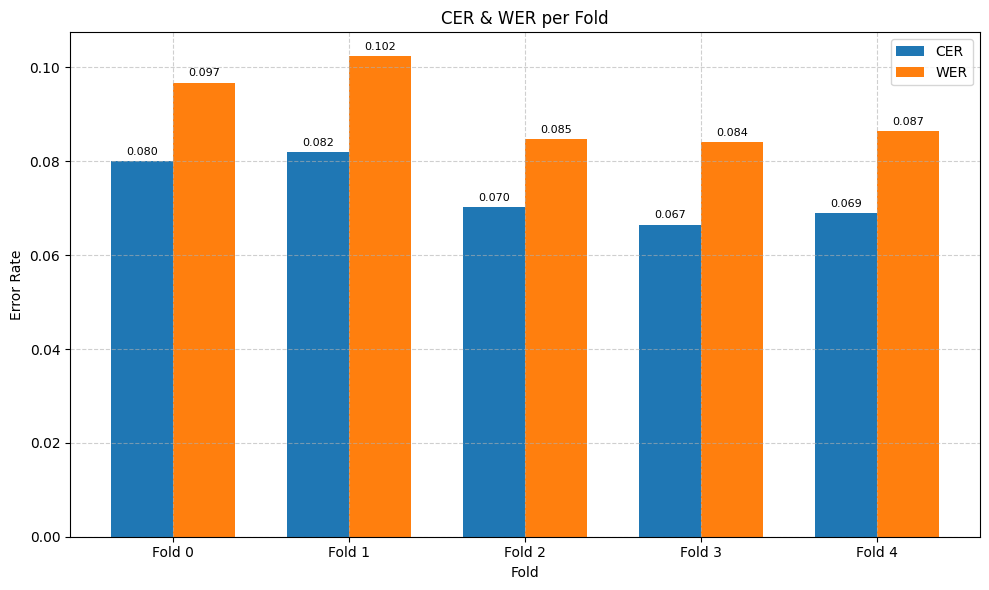

In [12]:
import json
import numpy as np
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.models import load_model
from tensorflow.keras.backend import ctc_decode
import matplotlib.pyplot as plt
import editdistance
import os
from collections import Counter

# === Load mapping label numerik ke fonem ===
with open('ngalagena_swara_labels.json', 'r', encoding='utf-8') as f:
    label_map = json.load(f)
int_to_label = {int(v): k for k, v in label_map.items()}

# === CTC decoding ===
def decode_prediction(pred, input_length):
    decoded, _ = ctc_decode(pred, input_length=np.ones(pred.shape[0]) * pred.shape[1], greedy=True)
    return decoded[0].numpy()

# === Evaluation Metrics ===
def cer(s1, s2):
    return editdistance.eval(s1, s2) / len(s2) if len(s2) > 0 else 1.0

def wer(ref, hyp):
    ref_words = ref.strip().split()
    hyp_words = hyp.strip().split()
    return editdistance.eval(ref_words, hyp_words) / len(ref_words) if len(ref_words) > 0 else 1.0

# === Evaluasi model per fold ===
def evaluate_model(model_path, json_path):
    model = load_model(model_path, compile=False)

    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    cer_list = []
    wer_list = []
    true_texts = []
    pred_texts = []

    for item in tqdm(data, desc=f"Evaluating {os.path.basename(model_path)}", leave=False):
        img_path = item["url_file"]
        label = item["label"]

        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
        img = tf.keras.preprocessing.image.img_to_array(img) / 255.0
        img = np.expand_dims(img, axis=0)

        y_pred = model.predict(img, verbose=0)
        decoded = decode_prediction(y_pred, input_length=np.array([y_pred.shape[1]]))

        pred_int = decoded[0]
        true_str = " ".join([int_to_label[i] for i in label])
        pred_str = " ".join([int_to_label.get(i, '') for i in pred_int if i in int_to_label])

        cer_list.append(cer(pred_str, true_str))
        wer_list.append(wer(true_str, pred_str))

        true_texts.append(true_str)
        pred_texts.append(pred_str)

    return np.mean(cer_list), np.mean(wer_list), true_texts, pred_texts

# === Main process ===
def main():
    json_path = "ctc_dataset/combined_file_list_validation.json"
    model_dir = "ctc_dataset/saved_models/finetune_v2"

    cer_scores = []
    wer_scores = []
    folds = []

    for i in range(5):
        model_path = os.path.join(model_dir, f"infer_model_fold_{i}.h5")
        cer_score, wer_score, true_texts, pred_texts = evaluate_model(model_path, json_path)
        cer_scores.append(cer_score)
        wer_scores.append(wer_score)
        folds.append(f"Fold {i}")

        error_counter = Counter()
        error_examples = []

        for true_text, pred_text in zip(true_texts, pred_texts):
            if true_text != pred_text:
                error_counter[true_text] += 1
                error_examples.append((true_text, pred_text))

        # 🔍 Tampilkan 10 kata yang paling sering salah dan prediksi yang muncul
        print(f"\n🔍 Fold {i} - Kata yang paling sering salah:")
        for word, count in error_counter.most_common(10):
            print(f"{word}: {count} kali salah")
        
        print(f"\n📌 Contoh kesalahan prediksi:")
        for true_text, pred_text in error_examples[:10]:
            print(f"  ✅ GT : {true_text}")
            print(f"  ❌ Pred: {pred_text}\n")

        print(f"✅ Fold {i} - CER: {cer_score:.4f}, WER: {wer_score:.4f}")

    # === Plotting grafik CER & WER ===
    x = np.arange(len(folds))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width/2, cer_scores, width, label='CER')
    rects2 = ax.bar(x + width/2, wer_scores, width, label='WER')

    ax.set_ylabel('Error Rate')
    ax.set_xlabel('Fold')
    ax.set_title('CER & WER per Fold')
    ax.set_xticks(x)
    ax.set_xticklabels(folds)
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.6)

    for rect in rects1 + rects2:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

    plt.tight_layout()
    plt.savefig("evaluation_plot.png")
    print("📊 Grafik evaluasi disimpan sebagai 'evaluation_plot.png'")

if __name__ == "__main__":
    main()


✅ Fold 0 - CER: 0.0800, WER: 0.0968
📄 Kesalahan disimpan ke errors_fold_0.json


✅ Fold 1 - CER: 0.0819, WER: 0.1024
📄 Kesalahan disimpan ke errors_fold_1.json


✅ Fold 2 - CER: 0.0703, WER: 0.0847
📄 Kesalahan disimpan ke errors_fold_2.json


✅ Fold 3 - CER: 0.0665, WER: 0.0842
📄 Kesalahan disimpan ke errors_fold_3.json


✅ Fold 4 - CER: 0.0690, WER: 0.0865
📄 Kesalahan disimpan ke errors_fold_4.json
🧾 Total kesalahan disimpan ke: evaluation_output/finetune_v2/top_errors_all_folds.json
📊 Visualisasi kesalahan disimpan ke: evaluation_output/finetune_v2/top_misclassified_words.png
📊 Grafik CER & WER disimpan ke: evaluation_output/finetune_v2/evaluation_plot.png


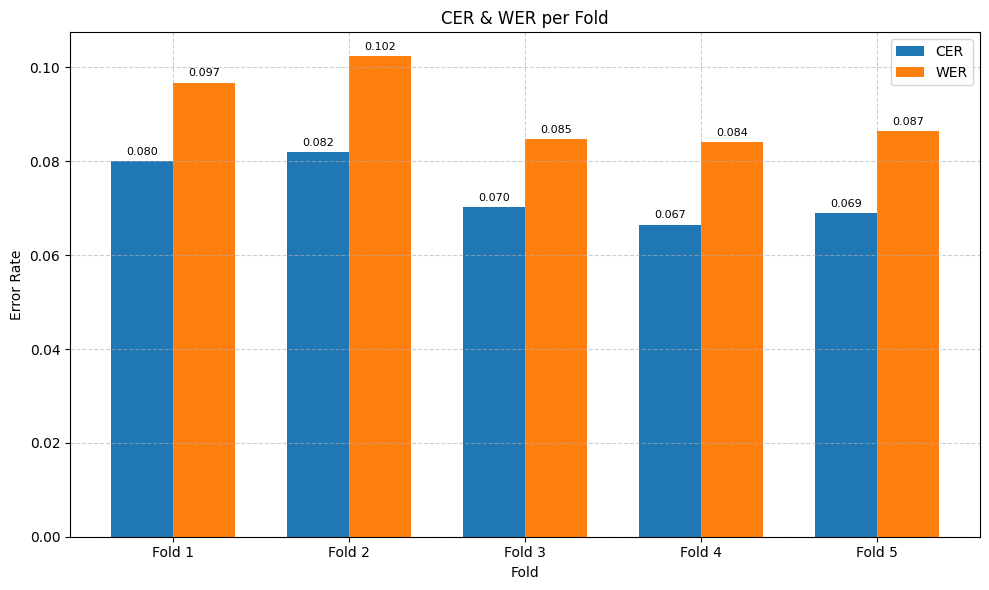

In [15]:
import json
import numpy as np
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.models import load_model
from tensorflow.keras.backend import ctc_decode
import matplotlib.pyplot as plt
import editdistance
import os
from collections import Counter

# === Load mapping label numerik ke fonem ===
with open('ngalagena_swara_labels.json', 'r', encoding='utf-8') as f:
    label_map = json.load(f)
int_to_label = {int(v): k for k, v in label_map.items()}

def decode_prediction(pred, input_length):
    decoded, _ = ctc_decode(pred, input_length=np.ones(pred.shape[0]) * pred.shape[1], greedy=True)
    return decoded[0].numpy()

def cer(s1, s2):
    return editdistance.eval(s1, s2) / len(s2) if len(s2) > 0 else 1.0

def wer(ref, hyp):
    ref_words = ref.strip().split()
    hyp_words = hyp.strip().split()
    return editdistance.eval(ref_words, hyp_words) / len(ref_words) if len(ref_words) > 0 else 1.0

def evaluate_model(model_path, json_path):
    model = load_model(model_path, compile=False)

    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    cer_list = []
    wer_list = []
    true_texts = []
    pred_texts = []

    for item in tqdm(data, desc=f"Evaluating {os.path.basename(model_path)}", leave=False):
        img_path = item["url_file"]
        label = item["label"]

        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
        img = tf.keras.preprocessing.image.img_to_array(img) / 255.0
        img = np.expand_dims(img, axis=0)

        y_pred = model.predict(img, verbose=0)
        decoded = decode_prediction(y_pred, input_length=np.array([y_pred.shape[1]]))

        pred_int = decoded[0]
        true_str = " ".join([int_to_label[i] for i in label])
        pred_str = " ".join([int_to_label.get(i, '') for i in pred_int if i in int_to_label])

        true_texts.append(true_str)
        pred_texts.append(pred_str)

        cer_list.append(cer(pred_str, true_str))
        wer_list.append(wer(true_str, pred_str))

    return np.mean(cer_list), np.mean(wer_list), true_texts, pred_texts

def main():
    json_path = "ctc_dataset/combined_file_list_validation.json"
    model_dir = "ctc_dataset/saved_models/finetune_v2"
    output_dir = "evaluation_output/finetune_v2"
    os.makedirs(output_dir, exist_ok=True)

    cer_scores = []
    wer_scores = []
    folds = []
    total_error_counter = Counter()

    for i in range(5):
        model_path = os.path.join(model_dir, f"infer_model_fold_{i}.h5")
        cer_score, wer_score, true_texts, pred_texts = evaluate_model(model_path, json_path)

        cer_scores.append(cer_score)
        wer_scores.append(wer_score)
        folds.append(f"Fold {i+1}")

        # === Hitung kesalahan kata ===
        error_counter = Counter()
        for true_text, pred_text in zip(true_texts, pred_texts):
            if true_text != pred_text:
                error_counter[true_text] += 1
                total_error_counter[true_text] += 1

        # Simpan per fold
        with open(os.path.join(output_dir, f"errors_fold_{i}.json"), 'w', encoding='utf-8') as f:
            json.dump(error_counter.most_common(), f, indent=4, ensure_ascii=False)

        print(f"✅ Fold {i} - CER: {cer_score:.4f}, WER: {wer_score:.4f}")
        print(f"📄 Kesalahan disimpan ke errors_fold_{i}.json")

    # === Simpan total kesalahan seluruh fold ===
    total_error_path = os.path.join(output_dir, "top_errors_all_folds.json")
    with open(total_error_path, 'w', encoding='utf-8') as f:
        json.dump(total_error_counter.most_common(), f, indent=4, ensure_ascii=False)

    print(f"🧾 Total kesalahan disimpan ke: {total_error_path}")

    # === Visualisasi Top 10 Kesalahan ===
    top_n = 10
    top_errors = total_error_counter.most_common(top_n)
    if top_errors:
        words = [w for w, _ in top_errors]
        counts = [c for _, c in top_errors]

        plt.figure(figsize=(10, 6))
        bars = plt.barh(words[::-1], counts[::-1], color='salmon')
        plt.xlabel("Jumlah Kesalahan")
        plt.title(f"Top {top_n} Kata yang Paling Sering Salah Prediksi")

        # Tambahkan angka di ujung bar
        for bar in bars:
            width = bar.get_width()
            plt.text(width + 0.5,              # posisi X (geser sedikit ke kanan)
                    bar.get_y() + bar.get_height() / 2,  # posisi Y tengah bar
                    f'{int(width)}',          # nilai angka
                    va='center', fontsize=10)

        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, "top_misclassified_words.png"))
        plt.close()
        print(f"📊 Visualisasi kesalahan disimpan ke: {output_dir}/top_misclassified_words.png")
    else:
        print("✅ Tidak ada kesalahan terdeteksi!")


    # === Visualisasi CER/WER ===
    x = np.arange(len(folds))
    width = 0.35
    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width/2, cer_scores, width, label='CER')
    rects2 = ax.bar(x + width/2, wer_scores, width, label='WER')

    ax.set_ylabel('Error Rate')
    ax.set_xlabel('Fold')
    ax.set_title('CER & WER per Fold')
    ax.set_xticks(x)
    ax.set_xticklabels(folds)
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.6)

    for rect in rects1 + rects2:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "evaluation_plot.png"))
    print(f"📊 Grafik CER & WER disimpan ke: {output_dir}/evaluation_plot.png")

if __name__ == "__main__":
    main()
